In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
import pathlib

data_dir = pathlib.Path("DATA") # indiquer chemin  où sont les données

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg'))) # compte le nb d'images dans le dossier
image_count

68

In [4]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]) 
CLASS_NAMES # liste des noms de dossiers

array(['D46D', 'F35', 'L1'], dtype='<U4')

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # 
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [6]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     color_mode='grayscale',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))
#On importe les images

Found 72 images belonging to 3 classes.


In [7]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
#Fonction d'affichage des images

In [8]:
def show_batch_greyscale(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(np.squeeze(image_batch[n]),cmap = "gray")
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
#Fonction d'affichage des images grissées

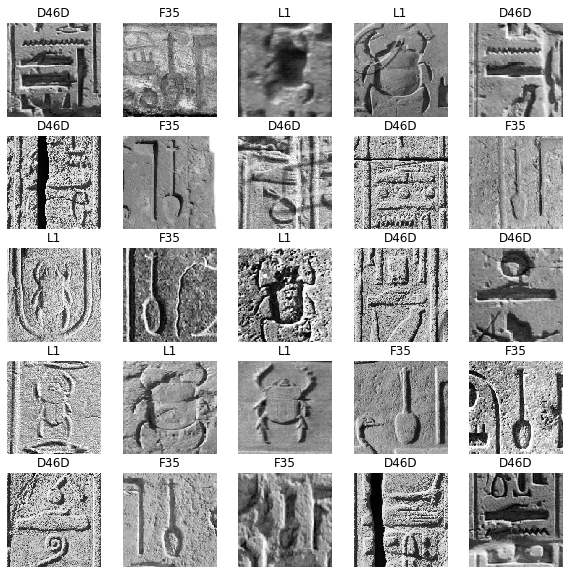

In [9]:
image_batch, label_batch = next(train_data_gen) #Pour séparer le label de l'image
#show_batch(image_batch, label_batch)
show_batch_greyscale(image_batch, label_batch)

In [10]:
image_batch.shape

(32, 224, 224, 1)

In [11]:
"""
def augm(datagen):
    datagen.fit(image_batch)
    augmT = np.array([])
    img_rows, img_cols = 224, 224
    for el in datagen.flow(image_batch):
        # Show 9 images
        for i in range(0, len(el)):
            if len(augmT) == 0 : augmT = np.append(augmT,[el[i]])
            #else : augmT = np.concatenate((augmT, [el[i]]))
            print(augmT)
            #plt.subplot(330 + 1 + i)
            #plt.imshow(np.squeeze(el[i]),cmap = "gray")
        # show the plot
        
        plt.show()
        break
    print(np.array(augmT.shape))
    print(augmT)
"""

'\ndef augm(datagen):\n    datagen.fit(image_batch)\n    augmT = np.array([])\n    img_rows, img_cols = 224, 224\n    for el in datagen.flow(image_batch):\n        # Show 9 images\n        for i in range(0, len(el)):\n            if len(augmT) == 0 : augmT = np.append(augmT,[el[i]])\n            #else : augmT = np.concatenate((augmT, [el[i]]))\n            print(augmT)\n            #plt.subplot(330 + 1 + i)\n            #plt.imshow(np.squeeze(el[i]),cmap = "gray")\n        # show the plot\n        \n        plt.show()\n        break\n    print(np.array(augmT.shape))\n    print(augmT)\n'

In [12]:
def augm(datagen):
    datagen.fit(image_batch)
    augmT = []
    for el in datagen.flow(image_batch,shuffle=False):
        for i in range(0, len(el)):
            if i == 0 : augmT.append(el[i])
            else : augmT.append(el[i])

        break
    augmT =  np.array(augmT)
    return augmT
        

In [13]:

#datagen = ImageDataGenerator(rotation_range=30)
#datagen = ImageDataGenerator(zoom_range=[0.5,1.0])
#datagen = ImageDataGenerator(brightness_range=[0.9,1.01])
#datagen = ImageDataGenerator(fill_mode='constant')
#datagen = ImageDataGenerator(cval=255)
datagen = ImageDataGenerator(width_shift_range=[-50,50])

new_img =  np.concatenate((image_batch,augm(datagen)))
new_label =  np.concatenate((label_batch,label_batch))


In [14]:
label = []
for item in label_batch:
    label.append(np.argmax(item))
label = np.array(label)

In [15]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(image_batch, label, test_size=0.25)

In [16]:
#sauvegarde weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="weights/checkpoint.h5",
                                                 save_weights_only=True,
                                                 verbose=1)

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64,input_dim=13))
model.add(layers.Dense(64, input_dim=13))
model.add(layers.Dense(13, activation='softmax'))

In [18]:
type(testY)

numpy.ndarray

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=10, 
                    validation_data=(testX, testY),callbacks=[cp_callback])

Train on 24 samples, validate on 8 samples
Epoch 1/10

Epoch 00001: saving model to weights/checkpoint.h5
24/24 [==============================] - 2s 74ms/sample - loss: 2.5597 - accuracy: 0.0000e+00 - val_loss: 2.0647 - val_accuracy: 0.3750
Epoch 2/10

Epoch 00002: saving model to weights/checkpoint.h5
24/24 [==============================] - 1s 43ms/sample - loss: 1.8213 - accuracy: 0.4167 - val_loss: 7.3171 - val_accuracy: 0.2500
Epoch 3/10

Epoch 00003: saving model to weights/checkpoint.h5
24/24 [==============================] - 1s 44ms/sample - loss: 8.8841 - accuracy: 0.2500 - val_loss: 1.1974 - val_accuracy: 0.2500
Epoch 4/10

Epoch 00004: saving model to weights/checkpoint.h5
24/24 [==============================] - 1s 46ms/sample - loss: 1.2066 - accuracy: 0.3750 - val_loss: 2.6738 - val_accuracy: 0.3750
Epoch 5/10

Epoch 00005: saving model to weights/checkpoint.h5
24/24 [==============================] - 1s 51ms/sample - loss: 2.1776 - accuracy: 0.4167 - val_loss: 2.1191 -

8/1 - 0s - loss: 1.1631 - accuracy: 0.3750


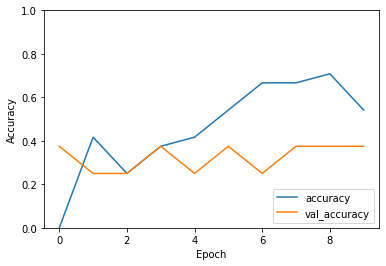

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testX,  testY, verbose=2)

In [21]:
print(test_acc)

0.375
